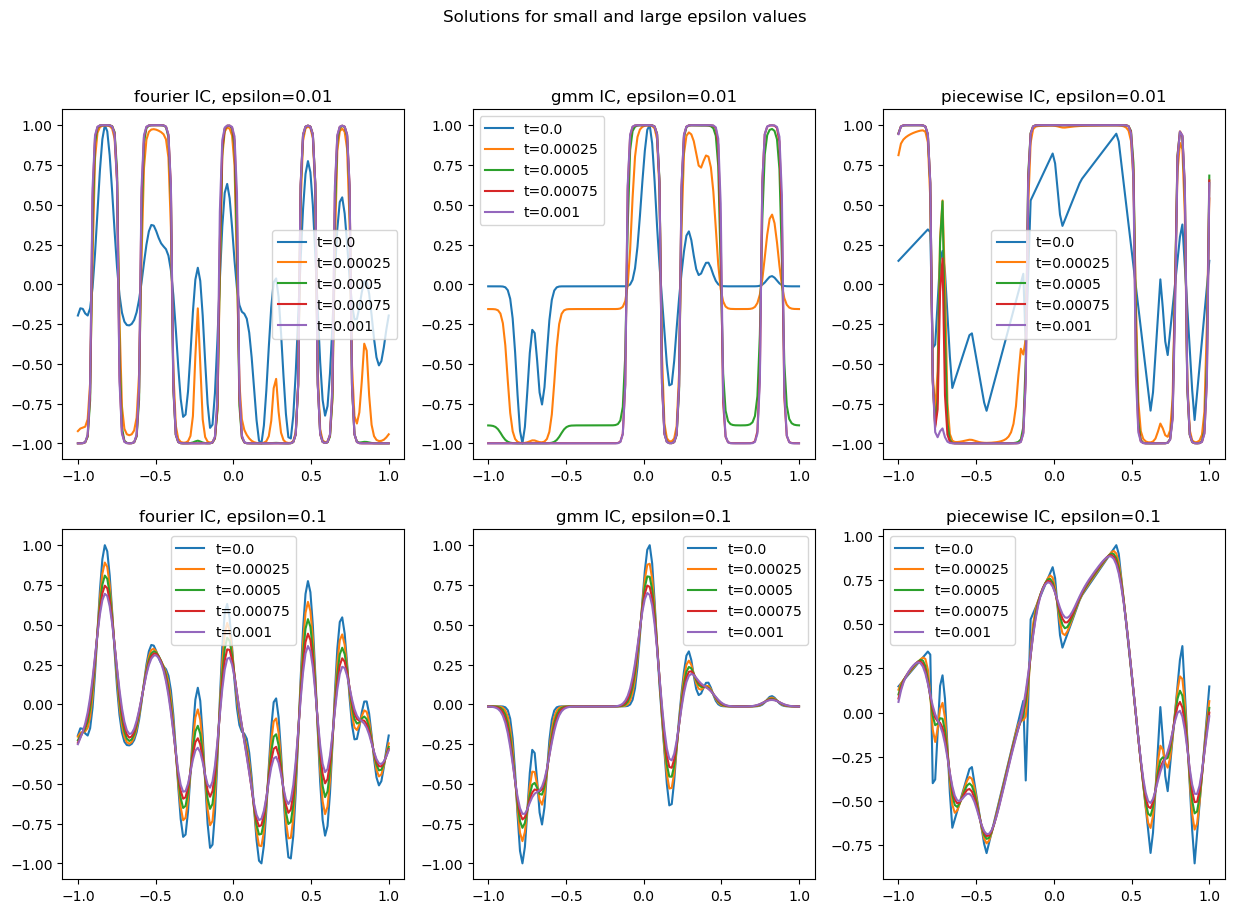

train data shape:  (5, 600, 5, 128)
train data shape:  (5, 600, 5, 128)
val data shape:  (7, 60, 5, 128)


In [147]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


def generate_fourier_ic(x, n_modes=None, seed=None):
    
    """
    Generate random Fourier series initial condition 
    1. Use random coefficients for sin and cos terms
    2. Ensure the result is normalized to [-1, 1]
    """
    if seed is not None:
        np.random.seed(seed)
    
    if n_modes is None:
        n_modes = np.random.randint(7, 20)

    # Generate coefficients for Fourier series
    sin_coeff = np.random.normal(size=n_modes)
    cos_coeff = np.random.normal(size=n_modes)

    # Prepare frequency modes, shape: (n_modes,)
    modes = np.arange(1, n_modes + 1)

    # Broadcast x to shape (1, len(x)) and modes to (n_modes, 1)
    # Then compute sin(...) and cos(...) of shape (n_modes, len(x))
    sin_part = sin_coeff[:, None] * np.sin(modes[:, None] * np.pi * x[None, :])
    cos_part = cos_coeff[:, None] * np.cos(modes[:, None] * np.pi * x[None, :])

    # Sum over n_modes to get a 1D result of shape (len(x),)
    u0 = sin_part.sum(axis=0) + cos_part.sum(axis=0)

    # Normalize to [-1, 1]
    min_val, max_val = u0.min(), u0.max()
    
    # Guard against potential zero denominator when max_val == min_val
    if max_val == min_val:
        return np.zeros_like(u0)  # All zeros if the function is constant

    u0 = (u0 - min_val) / (max_val - min_val)  # [0, 1]
    u0 = 2.0 * u0 - 1.0                        # [-1, 1]
    return u0
    

def generate_gmm_ic(x, n_components=None, seed=None):
    """
    Generate Gaussian mixture model initial condition using vectorized operations.
    
    1. Random number of components if n_components is None
    2. Use random means, variances, and weights
    3. Ensure result is normalized to [-1, 1]
    """
    if seed is not None:
        np.random.seed(seed)
    
    if n_components is None:
        n_components = np.random.randint(5, 15) # this is very smooth so we want to have more components
    
    # Generate means, variances, and weights
    means = np.random.uniform(-1, 1, size=n_components)
    variances = np.random.uniform(0.001, 0.001, size=n_components)
    weights = np.random.uniform(-1, 1, size=n_components)
    
    # Vectorized computation of GMM
    # Shape: (n_components, 1) for means, variances, and weights,
    #        plus (1, len(x)) for x.
    # We get a (n_components, len(x)) array of Gaussians, then sum across components.
    diff_sq = (x[None, :] - means[:, None])**2
    exps = np.exp(-diff_sq / (2 * variances[:, None]))  # shape (n_components, len(x))
    weighted_exps = weights[:, None] * exps
    u0 = weighted_exps.sum(axis=0)  # sum across n_components, shape (len(x),)

    # Normalize to [-1, 1]
    min_val, max_val = u0.min(), u0.max()
    if max_val == min_val:
        # Handle corner case if all Gaussians sum to constant
        return np.zeros_like(u0)
    
    u0 = (u0 - min_val) / (max_val - min_val)  # [0, 1]
    u0 = 2.0 * u0 - 1.0                        # [-1, 1]
    
    return u0


def generate_piecewise_ic(x, n_pieces=None, seed=None):
    """
    Generate a piecewise linear initial condition with periodic boundary conditions on x ∈ [-1, 1].
    Specifically:
      1) The function satisfies u(-1) = u(1).
      2) If x is outside [-1, 1], we wrap it back into the interval (mod 2).
      3) Between the sorted breakpoints b[i] and b[i+1], interpolate linearly.
    """
    if seed is not None:
        np.random.seed(seed)

    if n_pieces is None:
        n_pieces = np.random.randint(15, 40)

    # 1. Generate random breakpoints in (-1, 1), plus fix the endpoints at -1 and 1.
    #    We'll then sort them. This ensures the domain covers the entire [-1, 1].
    breakpoints = np.random.uniform(-1, 1, size=n_pieces)
    breakpoints[0]  = -1.0
    breakpoints[-1] =  1.0
    breakpoints = np.sort(breakpoints)

    # 2. Generate random function values for each breakpoint.
    values = np.random.uniform(-1, 1, size=n_pieces)
    # Enforce periodicity: value at x=-1 equals value at x=1.
    values[-1] = values[0]

    # 3. Precompute slopes for intervals [b[i], b[i+1]].
    #    slopes[i] = (values[i+1] - values[i]) / (b[i+1] - b[i])
    slopes = (values[1:] - values[:-1]) / (breakpoints[1:] - breakpoints[:-1])

    # 4. "Wrap" x into the domain [-1,1) using modulo 2 arithmetic:
    #    x_wrapped = ((x + 1) mod 2) - 1
    #    so anything less than -1 or greater than 1 is wrapped back.
    x_wrapped = (x + 1.0) % 2.0 - 1.0

    # (Optional) If x_wrapped == 1.0, shift it slightly so it doesn't exceed b[-1].
    # This prevents searchsorted from going out of range if x_wrapped equals exactly 1.0.
    mask_exact_one = (x_wrapped == 1.0)
    x_wrapped[mask_exact_one] = 1.0 - 1e-14

    # 5. Determine the piecewise interval for each x_wrapped
    #    side='right' => if x == b[i], we consider it in interval i rather than i-1
    #    subtract 1 => so that idx = i means  b[i] ≤ x < b[i+1]
    idx = np.searchsorted(breakpoints, x_wrapped, side='right') - 1

    # Clip idx so it cannot exceed n_pieces - 2
    # (the last interval is [b[n_pieces-2], b[n_pieces-1]] )
    idx_clipped = np.clip(idx, 0, n_pieces - 2)

    # 6. Piecewise linear interpolation:
    #      u(x) = values[i] + slopes[i] * (x - b[i])
    u0 = values[idx_clipped] + slopes[idx_clipped] * (x_wrapped - breakpoints[idx_clipped])

    return u0


def allen_cahn_rhs(t, u, epsilon, x_grid):
    """TODO: Implement Allen-Cahn equation RHS:
        ∂u/∂t = Δu - (1/ε²)(u³ - u)
    """
    dx = x_grid[1] - x_grid[0]
    
    # TODO: Compute Laplacian (Δu) with periodic boundary conditions
    laplacian = (np.roll(u, -1) - 2*u + np.roll(u, 1)) / dx**2
    
    # TODO: Compute nonlinear term -(1/ε²)(u³ - u)
    nonlinear = -1 / epsilon**2 * (u**3 - u)
    
    # TODO: Return full RHS
    return laplacian + nonlinear

def generate_dataset(n_samples, epsilon, x_grid, t_eval, ic_type='fourier', seed=None):
    """Generate dataset for Allen-Cahn equation."""
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize dataset array
    dataset = np.zeros((n_samples, len(t_eval), len(x_grid)))
    
    # Generate samples
    for i in range(n_samples):
        # Generate initial condition based on type
        if ic_type == 'fourier':
            u0 = generate_fourier_ic(x_grid, seed=seed+i if seed else None)
        elif ic_type == 'gmm':
            u0 = generate_gmm_ic(x_grid, seed=seed+i if seed else None)
        elif ic_type == 'piecewise':
            u0 = generate_piecewise_ic(x_grid, seed=seed+i if seed else None)
        else:
            raise ValueError(f"Unknown IC type: {ic_type}")
        
        # Solve PDE using solve_ivp
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )
        
        dataset[i] = sol.y.T
    
    return dataset

def generate_training_and_val_files():
    """Generate all datasets."""
    
    train_data = []
    val_data = []
    
    # Generate training datasets. want to end up with a mapping from eps to [n_samples * |ic_types|, |t_eval|, x_grid]
    for epsilon in epsilons:
        train_data_eps = []
        for ic_type in ic_types:
            train_data_eps.append(generate_dataset(n_train, epsilon, x_grid, t_eval, ic_type, seed=base_seed))
        train_data.append(np.concatenate(train_data_eps, axis=0))
        
        val_data_eps = []
        for ic in ic_types:
            val_data_eps.append(generate_dataset(n_test, epsilon, x_grid, t_eval, ic, seed=base_seed))
        val_data.append(np.concatenate(val_data_eps, axis=0))
            
    # Generate additional validation datasets
    for epsilon in additional_val_epsilons:
        val_data_eps = []
        for ic in ic_types:
            val_data_eps.append(generate_dataset(n_test, epsilon, x_grid, t_eval, ic, seed=base_seed))
        val_data.append(np.concatenate(val_data_eps, axis=0)) 

    print("train data shape: ", np.array(train_data).shape)
    

    
    # Save datasets as numpy files
    train_data = np.array(train_data)
    val_data = np.array(val_data)

    
    # Save datasets as numpy files
    np.save('train_data.npy', train_data, allow_pickle=True)
    print("train data shape: ", train_data.shape)

    
    np.save('val_data.npy', val_data, allow_pickle=True)
    print("val data shape: ", val_data.shape)

    return

def are_eps_sensible():
    """
        for the smallest and the largest epsilon values, for each IC type, solve one AC equatiion and plot the results to see if they are changing over time.
        for a too big or too small epsion, the solution would remain constant after 0.25 
    """
    small_eps = epsilons[0]
    large_eps = epsilons[-1]
    
    # generate two plots one for small epsilon and one for large epsilon
    # on each plot have 3 subplots for each IC type
    # on each plot have 5 lines for each time step
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Solutions for small and large epsilon values")
    
    for i, ic_type in enumerate(ic_types):
        # Small epsilon
        u = generate_dataset(1, small_eps, x_grid, t_eval, ic_type, seed=base_seed )[0]
        
        for j in range(len(t_eval)):
            axs[0, i].plot(x_grid, u[j], label=f"t={t_eval[j]}")
        axs[0, i].set_title(f"{ic_type} IC, epsilon={small_eps}")
        axs[0, i].legend()
        
        # Large epsilon
        u_large = generate_dataset(1, large_eps, x_grid, t_eval, ic_type, seed=base_seed )[0]
        
        for j in range(len(t_eval)):
            axs[1, i].plot(x_grid, u_large[j], label=f"t={t_eval[j]}")
        axs[1, i].set_title(f"{ic_type} IC, epsilon={large_eps}")
        axs[1, i].legend()
        
    plt.show()
    return
        
    
    

# Set up spatial grid
nx = 128
x_grid = np.linspace(-1, 1, nx)

# Set up temporal grid
t_eval = np.array([0.0, 0.25, 0.50, 0.75, 1.0])

# scaling of the time to make it more interesting -- the phase separation happens at [0,0.5] for eps ~~ 1e-3
t_eval = t_eval / 1000


# Parameters for datasets
ic_types = ['fourier', 'gmm', 'piecewise']  # Different initial condition types

epsilons = [0.01, 0.02, 0.05, 0.07, 0.1]  # Different epsilon values; should be in the range 0.01, 0.1 with this time scaling

n_train = 200   # Number of training samples per configuration
n_test = 20     # Number of test samples
base_seed = 40  # For reproducibility
additional_val_epsilons = [0.03, 0.005]  # Additional epsilons for validation

train_data = []
train_epsilons = []
val_data = []
val_epsilons = []



are_eps_sensible()

generate_training_and_val_files()



In [148]:


class SpectralConv1d(nn.Module):
    """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
    """
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        return torch.fft.irfft(out_ft, n=x.size(-1))



class FNOBlock(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        # TODO: Initialize the FNO block components
        # Should include:
        # - Spectral convolution
        # - Pointwise convolution
        # - Normalization (if needed)
        self.modes = modes
        self.width = width
        self.spectral_layer = SpectralConv1d(self.width, self.width, self.modes)
        self.conv_layer = nn.Conv1d(self.width, self.width, 1)

        self.activation = nn.ReLU()
    

    def forward(self, x):
        # TODO: Implement the FNO block forward pass
        # Remember to include skip connections
        
        x = self.spectral_layer(x)
        x = x + self.conv_layer(x)
        return self.activation(x)


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # TODO: Initialize time embedding
        # Consider using positional encoding or a learnable embedding

        # NOTE: using a learnable time embedding: 
        # time as input is of size (batch_size, 1)
        self.linear1 = nn.Linear(1, 4 * embedding_dim)  # first linear layer: (batch_size, 1) --> (batch_size, 4 * embedding_dim)
        self.linear2 = nn.Linear(4 * embedding_dim, 2 * embedding_dim)  # second linear layer: (batch_size, 4 * embedding_dim) -> (batch_size, 2 * embedding_dim)
        self.linear3 = nn.Linear(2 * embedding_dim, embedding_dim) # third linear layer: (batch_size, 2 * embedding_dim) -> (batch_size, 1 * embedding_dim)
        # Add activation functions between layers
        self.activation = nn.SiLU()  # Also known as Swish, works well for embeddings

    def forward(self, t):
        # TODO: Implement time embedding
        # t shape: (batch_size, 1)
        # return shape: (batch_size, embedding_dim)
        x = self.activation(self.linear1(t))
        x = self.activation(self.linear2(x))
        x = self.linear3(x)
        # return shape: (batch_size, embedding_dim)
        return x


class AllenCahnFNO(nn.Module):
    def __init__(self, modes=16, width=64, n_layers = 3):
        super().__init__()
        self.modes = modes
        self.width = width
        
        # TODO: Initialize model components
        # Consider:
        # - Epsilon embedding
        # - Time embedding
        # - Input/output layers
        # - FNO blocks

        # Time and epsilon embeddings
        self.time_embed = TimeEmbedding(embedding_dim=width)
        self.eps_embed = nn.Linear(1, width)
        
        # Initial processing of spatial input
        self.fc0 = nn.Linear(1, width)  # lift spatial dimension to width
        
        # FNO blocks
        self.fno_blocks = nn.ModuleList([
            FNOBlock(modes=modes, width=width) 
            for _ in range(n_layers)
        ])
        
        # Final output layer
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x, eps, t):
        """
        Args:
            x: Initial condition (batch_size, x_size)
            eps: Epsilon values (batch_size, 1)
            t: Time points (batch_size, n_steps)
        Returns:
            Predictions at requested timepoints (batch_size, n_steps, x_size)
        """
        # TODO: Implement the full model forward pass
        # 1. Embed epsilon and time
        # 2. Process spatial information with FNO blocks
        # 3. Generate predictions for each timestep
        
        batch_size, x_size = x.shape
        n_steps = t.shape[1]
        
        # Embed epsilon
        eps_embedded = self.eps_embed(eps)  # (batch_size, width)
        
        # Process initial condition
        x = x.unsqueeze(-1)     # (batch_size, x_size, 1)
        x = self.fc0(x)         # (batch_size, x_size, width)
        x = x.permute(0, 2, 1)  # (batch_size, width, x_size)
        
        # Initialize output tensor
        out = torch.zeros(batch_size, n_steps, x_size, device=x.device)
        
        # Process each timestep
        for i in range(n_steps):
            # Embed current timestep
            t_i = t[:, i:i+1]  # (batch_size, 1)
            t_embedded = self.time_embed(t_i)  # (batch_size, width)
            
            # Add time and epsilon embeddings to spatial features
            x_t = x + t_embedded.unsqueeze(-1) + eps_embedded.unsqueeze(-1)
            
            # Apply FNO blocks
            for block in self.fno_blocks:
                x_t = block(x_t)
            
            # Project to output space
            x_t = x_t.permute(0, 2, 1)  # (batch_size, x_size, width)
            x_t = F.gelu(self.fc1(x_t))
            x_t = self.fc2(x_t)
            out[:, i] = x_t.squeeze(-1)
        
        return out

def get_loss_func():
    """
    TODO: Define custom loss function(s) for training
    Consider:
    - L2 loss on predictions
    - Physical constraints (energy, boundaries)
    - Gradient-based penalties
    """
    def loss_function(pred, target, eps):
            # L2 loss on predictions
            mse_loss = F.mse_loss(pred, target)
            
            # Add physical constraints
            # Gradient-based penalty for smoothness
            eps = eps.unsqueeze(1).unsqueeze(1)
            print("eps shape: ", eps.shape)
            print(" shape of the gradients: ", torch.gradient(pred, dim=-1)[0].shape)
            print("shape of predictions: ", pred.shape)
            spatial_gradients = torch.gradient(pred, dim=-1)[0]
            smoothness_loss = torch.mean(spatial_gradients**2)
            
            # Energy constraint for Allen-Cahn
            # The energy functional is ∫ (ε²/2)|∇u|² + (1/4)(u² - 1)² dx
            energy_density = (eps**2/2) * spatial_gradients**2 + 0.25 * (pred**2 - 1)**2
            energy_loss = torch.mean(energy_density)
            
            # Combine losses with weights
            total_loss = mse_loss + 0.1 * smoothness_loss + 0.01 * energy_loss
            return total_loss
    
    return loss_function

def get_optimizer(model):
    """
    TODO: Configure optimizer and learning rate schedule
    Consider:
    - Adam with appropriate learning rate
    - Learning rate schedule for curriculum
    """
    # Adam optimizer with learning rate schedule
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Learning rate scheduler with warm-up and cosine decay
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=100,  # adjust based on your training setup
        steps_per_epoch=100,  # adjust based on your dataset size
        pct_start=0.1,  # warm-up period
        anneal_strategy='cos'
    )
    
    return optimizer, scheduler

def train_step(model, batch, optimizer, loss_func):
    """
    TODO: Implement single training step
    1. Forward pass
    2. Loss computation
    3. Backward pass
    4. Optimizer step
    Return loss value
    """

    model.train()
    optimizer.zero_grad()
    
    # Unpack batch
    x, eps, t, target = batch
    
    # Forward pass
    pred = model(x, eps, t)
    
    # Compute loss
    loss = loss_func(pred, target, eps)
    
    # Backward pass
    loss.backward()
    
    # Gradient clipping to prevent explosions
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Optimizer step
    optimizer.step()
    
    return loss.item()

def validation_step(model, batch, loss_func):
    """
    TODO: Implement single validation step
    Similar to train_step but without gradient updates
    Return loss value
    """
    model.eval()
    
    with torch.no_grad():
        # Unpack batch
        x, eps, t, target = batch
        
        # Forward pass
        pred = model(x, eps, t)
        
        # Compute loss
        loss = loss_func(pred, target, eps)
    
    return loss.item()

# Example usage:
def debug_model():
     # Model initialization
    model = AllenCahnFNO(modes=16, width=64)
    
    # Get loss function and optimizer
    loss_func = get_loss_func()
    optimizer, scheduler = get_optimizer(model)
    
    # Sample data
    batch_size, x_size = 32, 128
    x = torch.randn(batch_size, x_size)
    eps = torch.randn(batch_size, 1)
    t = torch.linspace(0, 1, 4)[None].expand(batch_size, -1)
    target = torch.randn(batch_size, 4, x_size)  # Example target data
    
    # Create batch
    batch = (x, eps, t, target)
    
    # Training step
    train_loss = train_step(model, batch, optimizer, loss_func)
    print(f"Training loss: {train_loss}")
    
    # Validation step
    val_loss = validation_step(model, batch, loss_func)
    print(f"Validation loss: {val_loss}")

# debug_model()


In [149]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader



class AllenCahnDataset(Dataset):
    def __init__(self, data, epsilon_values, time_points):
        """
        Args:
            data (np.ndarray): shape (num_epsilons, num_samples, num_timesteps, num_points)
                For example, if you have 3 epsilons, 10 samples each, 5 time steps,
                and 128 spatial points, then data.shape = (3, 10, 5, 128)

            epsilon_values (list or np.ndarray): shape (num_epsilons,)
                The corresponding epsilon values, e.g., [0.1, 0.05, 0.02]

            time_points (np.ndarray): shape (num_timesteps,)
                The time points at which the PDE solution is recorded,
                e.g. [0.0, 0.25, 0.5, 0.75, 1.0]
        """
        self.data = data
        self.epsilon_values = list(epsilon_values)  # ensure it's indexable
        self.time_points = time_points

        print("epsilon values: ", self.epsilon_values)

        # Build the list of valid (eps_index, sample_idx) pairs
        self.indices = []
        for eps_idx in range(len(self.epsilon_values)):
            num_samples = self.data[eps_idx].shape[0]
            for sample_idx in range(num_samples):
                self.indices.append((eps_idx, sample_idx))

        print("len of current indices: ", len(self.indices))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Retrieve the integer indices for epsilon and sample
        eps_index, sample_index = self.indices[idx]

        # Grab the trajectory for that epsilon/sample:
        # shape = (num_timesteps, num_points)
        trajectory = self.data[eps_index][sample_index]

        # Convert everything to torch.Tensor
        # "initial" = PDE solution at the first time point
        # "target"  = PDE solution at subsequent time points
        # "epsilon" = the float epsilon value
        # "times"   = the set of times for the target states
        sample = {
            'initial': torch.FloatTensor(trajectory[0]),     # shape: (num_points,)
            'target':  torch.FloatTensor(trajectory[1:]),    # shape: (num_timesteps-1, num_points)
            'epsilon': torch.FloatTensor([self.epsilon_values[eps_index]]),
            'times':   torch.FloatTensor(self.time_points[1:])  # shape: (num_timesteps-1,)
        }
        return sample


def create_subset_dataset(full_data, full_eps, subset_eps, time_points):
    """
    Given the full data array and list of all epsilons,
    create a new AllenCahnDataset for the subset of epsilons.
    """
    # 1) Find the indices of the desired epsilons in the full list
    subset_indices = [full_eps.index(eps) for eps in subset_eps]
    # 2) Slice the data for just those indices
    #    shape becomes (len(subset_indices), num_samples, num_timesteps, num_points)
    subset_data = full_data[subset_indices]
    # 3) Create a dataset with the smaller data array and smaller eps list
    return AllenCahnDataset(subset_data, subset_eps, time_points)


def train_model(model, 
                train_data, 
                val_data,
                epsilon_values,
                time_points, 
                batch_size=32, 
                epochs=100, 
                device='cuda',
                learning_rate=1e-3, 
                curriculum_steps=None):
    """
    Training loop with curriculum learning on epsilon values.

    curriculum_steps: list of (epoch, epsilon_subset) tuples
                     e.g., [(0, [0.1]), (20, [0.1, 0.05]), ...]
    """

    # Initially, use the full set of epsilons (or a user-chosen default).
    # If you want to start with just a subset, adjust below:
    train_dataset = create_subset_dataset(train_data, epsilon_values, epsilon_values, time_points)
    val_dataset   = create_subset_dataset(val_data,   epsilon_values, epsilon_values, time_points)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    model = model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):

        # Curriculum Step: if we have a scheduled change in the subset of epsilons
        if curriculum_steps:
            for step_epoch, eps_subset in curriculum_steps:
                if epoch == step_epoch:
                    train_dataset = create_subset_dataset(train_data,
                                                          epsilon_values,
                                                          eps_subset,
                                                          time_points)
                    train_loader = DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
                    print(f"Curriculum update: now training on epsilon values {eps_subset}")

        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            # Forward pass (adjust based on your model's signature)
            pred = model(batch['initial'], batch['epsilon'], batch['times'])

            # Compute loss (replace nn.MSELoss() with your desired loss)
            loss = nn.MSELoss()(pred, batch['target'])

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                pred = model(batch['initial'], batch['epsilon'], batch['times'])
                val_loss += nn.MSELoss()(pred, batch['target']).item()

        train_loss /= len(train_loader)
        val_loss   /= len(val_loader)

        print(f"Epoch {epoch}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

    return model

# NOTE: tried to run it locally on Apple Silicon using mps but the complex multiplication in the SpectralConv1d is not supported 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available?", torch.cuda.is_available())

print("Using device:", device)


# Example curriculum steps
curriculum_steps = [
    (0, [0.1]),              # Start with largest epsilon
    (20, [0.1, 0.05]),       # Add medium epsilon
    (40, [0.1, 0.05, 0.02])  # Add smallest epsilon
]
epsilon_values = [0.1, 0.05, 0.02]
time_points = np.array([0.0, 0.25, 0.50, 0.75, 1.0])

val_epsilons = [0.03, 0.06]  # Additional epsilons for validation


# load the datasets:
train_data = np.load('train_data.npy', allow_pickle=True)
val_data = np.load('val_data.npy', allow_pickle=True)

print("train dataset shape: ", train_data.shape)
print("test dataset shape: ", val_data.shape)


# initialise an FNO and train it using the proposed curriculum:
model = AllenCahnFNO(modes=16, width=64)
model = model.to(device)

# Training
trained_model = train_model(
    model, train_data, val_data, epsilon_values, time_points, 
    batch_size=32, epochs=100, device= device,
    curriculum_steps=[
        (0, [0.1]),           # Start with largest epsilon
        (20, [0.1, 0.05]),    # Add medium epsilon
        (40, [0.1, 0.05, 0.02])  # Add smallest epsilon
    ]
)


CUDA Available? False
Using device: cpu
train dataset shape:  (5, 600, 5, 128)
test dataset shape:  (7, 60, 5, 128)
epsilon values:  [0.1, 0.05, 0.02]
len of current indices:  1800
epsilon values:  [0.1, 0.05, 0.02]
len of current indices:  180
epsilon values:  [0.1]
len of current indices:  600
Curriculum update: now training on epsilon values [0.1]


KeyboardInterrupt: 

Epsilon values: [0.1, 0.05, 0.02]
Data shape: (9, 10, 5, 128)
Total dataset length: 30


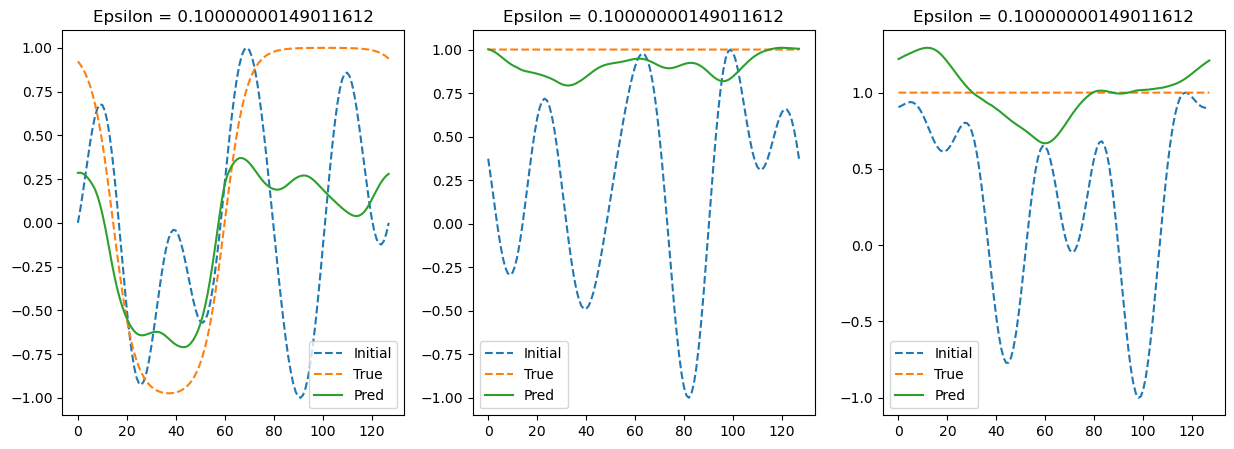

In [ ]:
import matplotlib.pyplot as plt 
# Evaluate the trained model, compare to the ground truth on three samples
trained_model.eval()
test_dataset = AllenCahnDataset(train_data, epsilon_values, time_points)
test_loader = DataLoader(test_dataset, batch_size=3)
device = 'cpu'  # or device = 'cuda' if you do have a GPU + proper installation

# Get a batch of samples and plot for this batch only
batch = next(iter(test_loader))
batch = {k: v.to(device) for k, v in batch.items()}
initial = batch['initial']
epsilon = batch['epsilon']
times = batch['times']
target = batch['target']

# Forward pass
pred = trained_model(initial, epsilon, times)

# Plot the results
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(initial[i].cpu(), label='Initial', linestyle='--')
    plt.plot(target[i, 0].cpu(), label='True', linestyle='--')
    plt.plot(pred[i, 0].detach().cpu(), label='Pred')
    plt.legend()
    plt.title(f"Epsilon = {epsilon[i].item()}")
        
